In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
my_font = FontProperties(fname=r"c:\windows\fonts\SimHei.ttf",size=12)

In [12]:
class WindDataSet(Dataset):
    def __init__(self,path,num_steps=50):
        self.data = []
        file = pd.read_csv(path,skiprows=1)
        self.wind = np.array(file['wind speed at 10m (m/s)']).reshape(1,-1)[0]
        wind_len = len(self.wind)
        for i in range(0,wind_len-num_steps-1):
            self.data.append((self.wind[i:i+num_steps],self.wind[i+num_steps]))
        self.data = self.data[:int(len(self.data)/500)*500]
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        seq,pre = self.data[index]
        return seq,pre


In [13]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
try_gpu()

device(type='cuda', index=0)

In [14]:
INPUT_SIZE=1
HIDDEN_SIZE=128
BATCH_SIZE=500
DROP_RATE=0.2

class lstm(nn.Module):
    def __init__(self):
        super(lstm,self).__init__()
        self.rnn = nn.LSTM(input_size=INPUT_SIZE,hidden_size=HIDDEN_SIZE)
        self.fc = nn.Linear(HIDDEN_SIZE,1)
    def forward(self,x,state):
        out,state = self.rnn(x.T.reshape((x.shape[1],-1,1)),state)
        out = self.fc(out)
        return out[-1],state
    def begin_state(self,batch_size,device):
        return (torch.zeros((1,batch_size,HIDDEN_SIZE),device=device),torch.zeros((1,batch_size, HIDDEN_SIZE), device=device))

In [15]:
net = lstm()
lr = 0.001
device = try_gpu()
print(device)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
loss = nn.MSELoss()
epochs = 10
num_steps=50

cuda:0


In [16]:
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta/norm

In [22]:

def train_epoch(epoch,net,train_loader,device,train_loss):
    net = net.to(device)
    net.train()
    #state=net.begin_state(batch_size=BATCH_SIZE, device=device)
    runing_loss=0
    for batch_idx,(X,y) in enumerate(train_loader):
        state=net.begin_state(batch_size=BATCH_SIZE, device=device)
        for s in state:
            s.detach_()
        optimizer.zero_grad()
        X,y = X.to(torch.float32).to(device),y.to(torch.float32).T.to(device)
        y_hat,state = net(X,state)
        y_hat = y_hat.reshape(-1)
        l = loss(y_hat,y).mean()
        l.backward()
        grad_clipping(net, 1)
        optimizer.step()
        runing_loss += l.item()
        if batch_idx%200 == 199:
            print(f'epoch:{epoch+1},batch_idx:{batch_idx+1},running_loss:{runing_loss/200}')
            train_loss.append(l.item())
            runing_loss=0


In [23]:
dataset = WindDataSet('./datasets/1.csv',num_steps)
print(dataset.__len__())

105000


In [24]:
def save_net(path = 'wind.pt', net=None):
    torch.save(net.state_dict(),path)

In [25]:
def train(epochs):
    train_loss = []
    for epoch in range(epochs):
        for i in range(120):
            #print(f"file:{i+1}")
            dataset = WindDataSet(f'./datasets/{i}.csv',num_steps)
            train_loader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=4)
            train_epoch(epoch,net,train_loader,device,train_loss)
        print(f'###epoch:{epoch+1},train_loss:{train_loss[-1]}')
        save_net(path=f"newdata-epoch{epoch}.pt",net=net.to('cpu'))
    

In [26]:
train(epochs)

epoch:1,batch_idx:200,running_loss:0.08313675701327156
epoch:1,batch_idx:200,running_loss:0.09370529716194141
epoch:1,batch_idx:200,running_loss:0.08560036364011467
epoch:1,batch_idx:200,running_loss:0.1028739257750567
epoch:1,batch_idx:200,running_loss:0.11890515973675064
epoch:1,batch_idx:200,running_loss:0.13225625535065774
epoch:1,batch_idx:200,running_loss:0.13857130833668635
epoch:1,batch_idx:200,running_loss:0.13690821546129883
epoch:1,batch_idx:200,running_loss:0.14174206259893254
epoch:1,batch_idx:200,running_loss:0.14009527354035525
epoch:1,batch_idx:200,running_loss:0.1361288089089794
epoch:1,batch_idx:200,running_loss:0.13441385461192112
epoch:1,batch_idx:200,running_loss:0.10482332603482064
epoch:1,batch_idx:200,running_loss:0.1104613512486685
epoch:1,batch_idx:200,running_loss:0.11776433555060066
epoch:1,batch_idx:200,running_loss:0.12114444010017905
epoch:1,batch_idx:200,running_loss:0.1256874467234593
epoch:1,batch_idx:200,running_loss:0.12999431093980093
epoch:1,batch_

KeyboardInterrupt: 

In [11]:
def load_net(path='wind (1).pt',net=None):
    net.load_state_dict(torch.load(path))
load_net(net=net)

In [12]:
def predict(prefix,num_preds,net,device):
    state = net.begin_state(batch_size=1,device=device)
    outputs = [prefix[0]]
    get_input = lambda:torch.tensor([outputs[-1]],device=device).reshape(1,1)
    for y in prefix[1:]:
        _,state = net(get_input(),state)
        outputs.append(y)
    for _ in range(num_preds):
        y,state = net(get_input(),state)
        outputs.append(y.reshape(1).detach()[0])
    tmp = []
    for t in outputs:
        tmp.append(t.item())
    outputs =tmp
    return outputs#torch.cat(outputs,dim=1)


In [22]:
test_dataset = WindDataSet('../data/wind_dataset144-2014/wind_dataset144//141.csv',num_steps=100)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)
preds,truth=None,None
for batch_idx,(X, y) in enumerate(test_loader):
    if batch_idx == 2:
        X = (X.reshape(-1).to(torch.float32))
        preds = predict(X,100,net.to(device),device)
    if batch_idx == 3:
        truth = np.array(X)
        break
truth = np.array(truth.reshape(-1))
print((preds[100:]))
print((truth))



[8.060556411743164, 8.065326690673828, 8.074728965759277, 8.085586547851562, 8.098655700683594, 8.112531661987305, 8.126437187194824, 8.139354705810547, 8.150915145874023, 8.16058349609375, 8.168395042419434, 8.174407005310059, 8.178900718688965, 8.182125091552734, 8.184406280517578, 8.185968399047852, 8.187006950378418, 8.187623977661133, 8.187882423400879, 8.187784194946289, 8.187312126159668, 8.186429023742676, 8.185104370117188, 8.183313369750977, 8.181047439575195, 8.178311347961426, 8.17512321472168, 8.171510696411133, 8.16750431060791, 8.163140296936035, 8.158451080322266, 8.15346908569336, 8.148221969604492, 8.142733573913574, 8.137024879455566, 8.13111400604248, 8.125015258789062, 8.118741989135742, 8.112306594848633, 8.105720520019531, 8.098995208740234, 8.092142105102539, 8.085174560546875, 8.078104019165039, 8.070940971374512, 8.063697814941406, 8.056384086608887, 8.04901123046875, 8.041586875915527, 8.0341215133667, 8.02662467956543, 8.01910400390625, 8.011567115783691, 8.

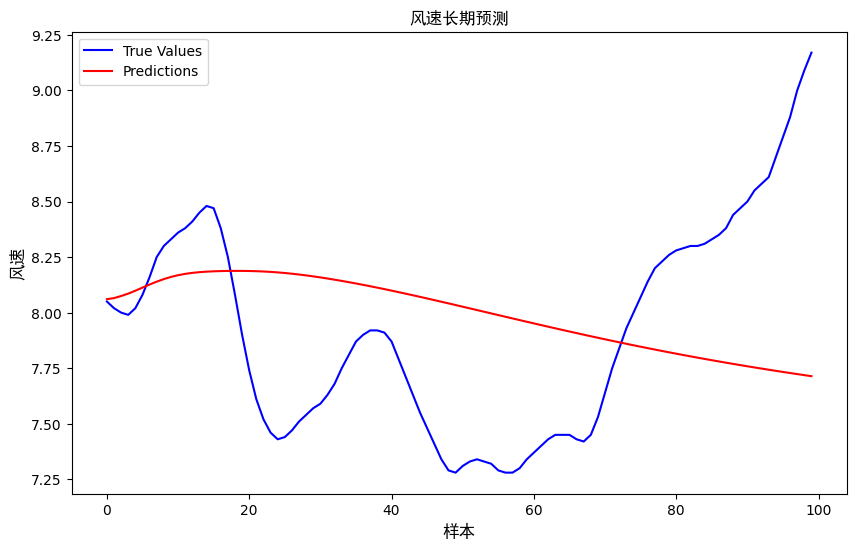

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(truth, label='True Values', color='blue')
plt.plot(preds[100:], label='Predictions', color='red')
plt.title('风速长期预测',fontproperties=my_font)
plt.xlabel('样本',fontproperties=my_font)
plt.ylabel('风速',fontproperties=my_font)
plt.legend()
plt.show()

In [25]:
test_dataset = WindDataSet('../data/wind_dataset144-2014/wind_dataset144//141.csv',num_steps=100)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)
preds,truthes=[],[]
for batch_idx,(X, y) in enumerate(test_loader):
        if batch_idx > 100:
                break
        X = (X.reshape(-1).to(torch.float32))
        pred = predict(X,1,net.to(device),device)
        truth = np.array(y).reshape(-1)[-1]
        preds.append(np.array(pred)[-1])
        truthes.append(truth)
print((preds[100:]))
print((truth))



[6.46370792388916]
6.43


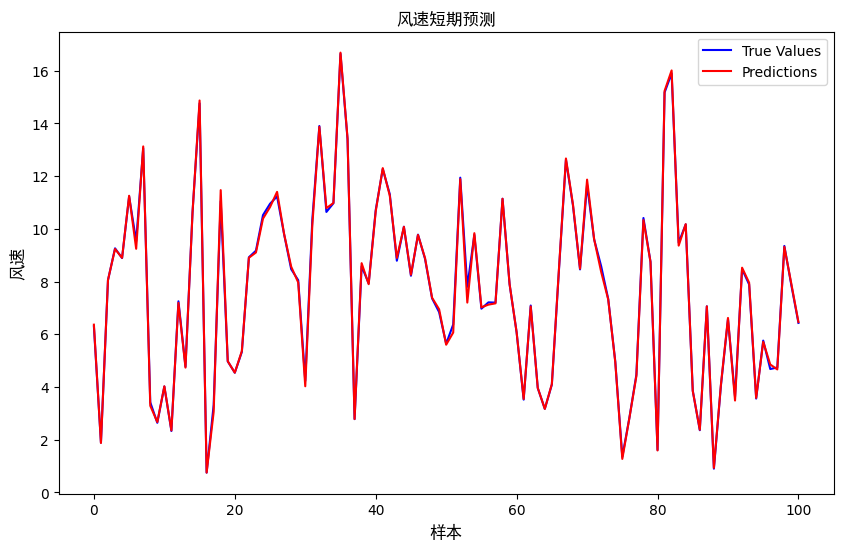

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(truthes, label='True Values', color='blue')
plt.plot(preds, label='Predictions', color='red')
plt.title('风速短期预测',fontproperties=my_font)
plt.xlabel('样本',fontproperties=my_font)
plt.ylabel('风速',fontproperties=my_font)
plt.legend()
plt.show()